# CS446/546 - Class Session 9 - Components

In this class session we are going to compute the local clustering coefficient of all vertices in the undirected human
protein-protein interaction network (PPI), in two ways -- first without using `igraph`, and the using `igraph`. We'll obtain the interaction data from the Pathway Commons SIF file (in the `shared/` folder), we'll make an "adjacency forest" representation of the network, and we'll manually compute the local clustering coefficient of each vertex (protein) in the network using the "enumerating neighbor pairs" method described by Newman. Then we'll run the same algorithm using the `transitivity` function in `igraph`, and we'll compare the results in order to check our work. Grad students:  you should also group vertices by their "binned" vertex degree k (bin size 50, total number of bins = 25) and plot the average local clustering coefficient for the vertices within a bin, against the center k value for the bin, on log-log scale (compare to Newman Fig. 8.12)

In [4]:
suppressPackageStartupMessages(library(igraph))

Step 1:  load in the SIF file as a data frame `sif_data`, using the `read.table` function

In [5]:
sif_data <- read.table("shared/pathway_commons.sif",
                       sep="\t",
                       header=FALSE,
                       stringsAsFactors=FALSE,
                       col.names=c("species1",
                                   "interaction_type",
                                   "species2"),
                       quote="",
                       comment.char="")

Step 2:  restrict the interactions to protein-protein undirected ("in-complex-with", "interacts-with"), using the `%in%` operator and using array indexing `[`, and include only the two species columns. The restricted data frame should be called `interac_ppi`.

In [6]:
interac_ppi <- sif_data[sif_data$interaction_type %in% c("in-complex-with",
                                                         "interacts-with"), c(1,3)]

Step 3: restrict the data frame to only the unique interaction pairs of proteins (ignoring the interaction type), using the `unique` function.  Make an igraph `Graph` object from the data frame, using `graph_from_data_frame`.

In [7]:
interac_ppi_unique <- unique(interac_ppi)
ppi_igraph <- graph_from_data_frame(interac_ppi_unique, directed=FALSE)

Step 4: Obtain an adjacency list representation of the graph, as `ppi_adj_list`, using the function `as_adj_list`.  Refer to class session 4.

In [12]:
ppi_adj_list <- as_adj_list(ppi_igraph)

Step 5: Make an adjacency forest data structure, using R environments (recall the function to create an environment is `new.env`). Refer to class session 5.  The adjacency forest data structure should be called `ppi_adj_forest`.

In [13]:
get_adj_forest <- function(adj_list) {
    n <- length(adj_list)
    prot_names <- names(adj_list)
    myforest <- new.env()
    for (i in 1:n) {
        vertex_name <- prot_names[i]
        childtree <- new.env()
        for (neighbor_protein in names(adj_list[[i]])) {
            childtree[[neighbor_protein]] <- 1
        }
        myforest[[vertex_name]] <- childtree
    }
    myforest
}
ppi_adj_forest <- get_adj_forest(ppi_adj_list)

Step 6: Compute the local clustering coefficient (Ci) values for the first 100 vertices (do timing on this operation); for any vertex with degree=1, its Ci value can be NA.  You will probably want to first write a function that will compute Ci for a single vertex, using the adjacency forest.  Then use `ls` on the adjacency forest to get a character vector of the names of all the vertices in the graph, then for the first 100 vertices, call your function.  You can use `sapply` to do that, or you can choose to use a `for` loop.

In [17]:
N <- length(ppi_adj_forest)

system.time( civals <- sapply(ls(ppi_adj_forest)[1:100], 
      function(vertex_name) {
          vertex_env <- ppi_adj_forest[[vertex_name]]
          neighbors <- ls(vertex_env)
          nneighbors <- length(neighbors)
          paircount <- sum(na.omit(unlist(apply(expand.grid(neighbors, 
                                                            neighbors, 
                                                            stringsAsFactors=FALSE), 1, 
                                         function(my_pair) {
                                              if (my_pair[1]>=my_pair[2]) {
                                                  return(NA)
                                              }
                                                ppi_adj_forest[[my_pair[1]]][[my_pair[2]]]
                                         }))))
          ci <- if (nneighbors > 1) {
              paircount/(nneighbors*(nneighbors-1)/2)
          } else {
              NA
          }
      }))

head(civals)

   user  system elapsed 
  1.736   0.000   1.737 

A1BG        A1CF         A2M       A2ML1      A4GALT       A4GNT 
0.067212157 0.037433155 0.066597867 0.000000000 0.000000000 0.005847953

Step 7: Calculate the local clustering coefficients using `igraph` (function `transitivity`
with option `type="undirected"`), and do timing on the call to `transitivity`)

In [18]:
system.time(civals_igraph <- transitivity(ppi_igraph, type="localundirected", vids=ls(ppi_adj_forest)[1:100]))

   user  system elapsed 
  0.088   0.000   0.086 


Step 8: Compare your Ci values to those that you got from `igraph`, using a scatter plot

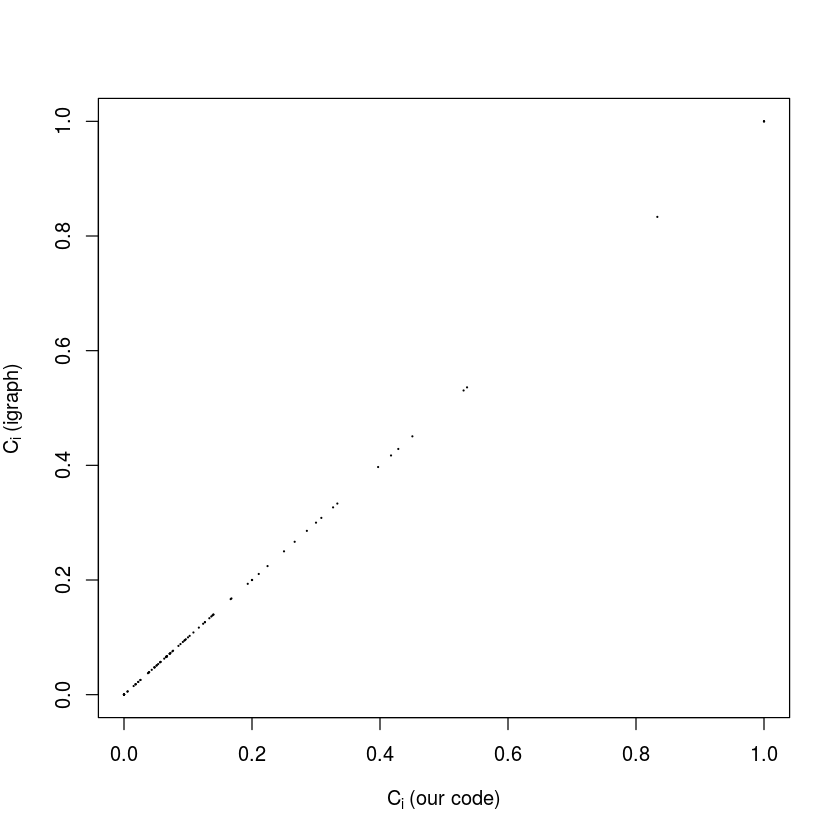

In [19]:
plot(civals, civals_igraph, cex=0.1, xlab=expression(C[i]~"(our code)"), ylab=expression(C[i]~"(igraph)"))

Step 9:  scatter plot the average log(Ci) vs. log(k) (i.e., local clustering coefficient vs. vertex degree) for 25 bins of vertex degree, with each bin size being 50 (so we are binning by k, and the bin centers are 50, 100, 150, 200, ...., 1250)

In [23]:
vertex_degrees <- degree(ppi_igraph)
vertex_Ci <- transitivity(ppi_igraph, type="localundirected")
kvals <- 1:max(vertex_degrees)
avg_Ci_vals <- sapply(1:25, function(kval) {
    inds <- which(round(vertex_degrees/50) == kval)
    mean(vertex_Ci[inds])
})


How many vertices have an `NA` value for their local clustering coefficient?

In [13]:
length(which(is.na(civals_igraph)))

[1] 1201

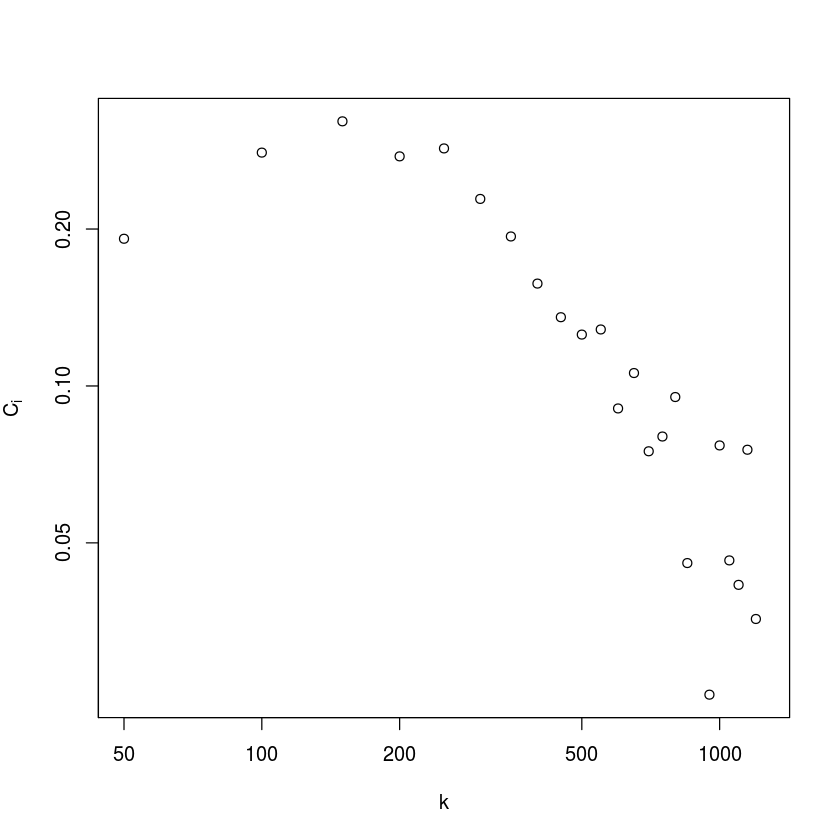

In [22]:
plot(50*(1:25), avg_Ci_vals, log="xy", xlab=expression(k), ylab=expression(C[i]))